In [1]:
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics

In [2]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

# Handling the data

In [3]:
# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("y_train.csv", index_col=0).T

In [4]:
#Change it with what you need
#For the training with only images or images and features i took data_train_1 = [:700] and data_train_2 = [700:800] for validation

data_train_1 = data_train[:350]
unlabeled_train_data = data_train[800:]
label_train_1 = labels_train[:350]
unlabeled_train_labels = labels_train[800:]

data_train_2 = data_train[350:700]
label_train_2 = labels_train.iloc[350:700]

data_val = data_train[700:800]
label_val = labels_train.iloc[700:800]

In [5]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


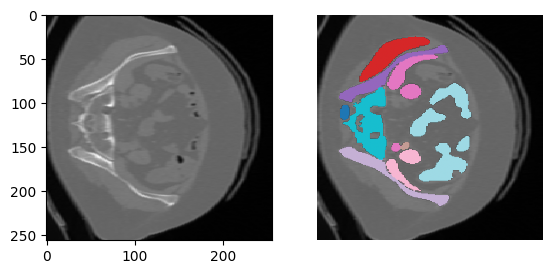

In [6]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

# Let's try it on a slide and ites segmentation mask
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
plot_slice_seg(data_train[0], labels_train.iloc[0].values.reshape((256,256)))

# Let's compute a baseline

In [7]:
# Let's take a very basic watershed baseline
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

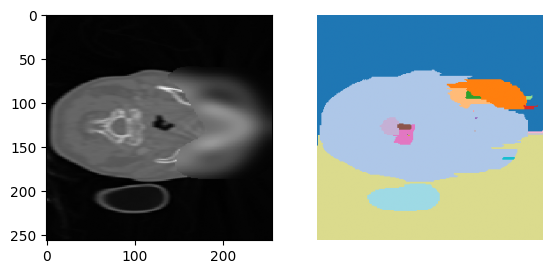

In [8]:
# Let's display the results
# Not too bad!
plot_slice_seg(data_train[2], compute_baseline_one_sample(data_train[2]))

## Let's measure its performances

In [9]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [10]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

NameError: name 'data_val' is not defined

In [10]:
NUM_CLASSES = 54 # 55 classes in total, but the first one is the background


def dice_image(prediction, ground_truth):
    intersection = np.sum(prediction * ground_truth)
    if np.sum(prediction) == 0 and np.sum(ground_truth) == 0:
        return np.nan
    return 2 * intersection / (np.sum(prediction) + np.sum(ground_truth))


def dice_multiclass(prediction, ground_truth):
    dices = []
    for i in range(1, NUM_CLASSES + 1): # skip background
        dices.append(dice_image(prediction == i, ground_truth == i))
    return np.array(dices)

def dice_pandas(y_true_df: pd.DataFrame, y_pred_df: pd.DataFrame) -> float:
    """Compute the dice score for each sample in the dataset and then average it"""
    y_pred_df = y_pred_df.T
    y_true_df = y_true_df.T
    individual_dice = []
    for row_index in range(y_true_df.values.shape[0]):
        dices = dice_multiclass(y_true_df.values[row_index].ravel(), y_pred_df.values[row_index].ravel())
        individual_dice.append(dices)

    final = np.stack(individual_dice)
    # First, average over images for each class
    # Then, average over classes
    cls_dices = np.nanmean(final, axis=0)
    return float(np.nanmean(cls_dices))


In [14]:
# Compute the metric on the validation set
dice_pandas(labels_val, labels_val_predicted_baseline)
# We get => (0.0011196021617737601); Not so bad, but room for improvements!
# Let's see if you can do better!

0.001158922567158145

## GET FEATURES

In [11]:
from transformers import AutoModel
from PIL import Image
import requests
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Custom dataset class for multiple grayscale CT scans, this is what we put our data in
class CTDataset(Dataset):
    def __init__(self, images):
        """
        images: A list or NumPy array of shape (N, 256, 256) containing grayscale CT scans.
        """
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Get (256, 256) image
        #return img
        return preprocess_image(img)  # Convert to 3-channel 224x224 tensor
# # Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define preprocessing transforms
transform = T.Compose([
    T.Resize(224),  # Resize to DINOv2 expected input size
    T.ToTensor(),  # Convert to tensor
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])  # Normalize
])
# transform = T.Compose([
#     T.Resize(224),
#     T.CenterCrop(224),
#     T.ToTensor(),
#     T.Normalize(mean=[0.5], std=[0.5]),
# ])

def preprocess_image(image_array):
    """
    Convert grayscale (256x256) CT scan to a format usable by DINOv2.
    - image_array: NumPy array of shape (256, 256), values in range [0,1].
    - Returns: Tensor of shape (3, 224, 224) ready for DINOv2.
    """
    img = np.stack([image_array] * 3, axis=-1)  # Convert grayscale (H,W) → RGB (H,W,3)
    img = Image.fromarray((img * 255).astype(np.uint8))  # Convert to PIL image
    img = transform(img)  # Apply resizing and normalization
    return img

In [15]:
#THE CELL WHERE YOU CAN CHANGE STUFF

#LOAD MODEL HERE
#in order from smallest to largest, dinov2_vits14 is the smallest model
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14').to(device)
# LOAD DATASET HERE

#if test data, define the test data, and then put it inside CTDataset
Dataset_train_1 = CTDataset(data_train_1)
DataLoader_train_1 = DataLoader(Dataset_train_1, batch_size=8, shuffle=False)

Dataset_train_2 = CTDataset(data_train_2)
DataLoader_train_2 = DataLoader(Dataset_train_2, batch_size=8, shuffle=False)

Dataset_test = CTDataset(data_test)
DataLoader_test = DataLoader(Dataset_test, batch_size=8, shuffle=False)

Dataset_val = CTDataset(data_val)
DataLoader_val = DataLoader(Dataset_val, batch_size=8, shuffle=False)

# Extract features for all images
# train_patch_features_list = []
# train_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(train_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         #print(features_dict)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         train_patch_features_list.append(patch_features)
#         train_cls_features_list.append(cls_features)
#         #train_features_list.append(features.cpu().numpy())

# valid_patch_features_list = []
# valid_cls_features_list = []
# with torch.no_grad():
#     for batch in tqdm(valid_dataloader):
#         batch = batch.to(device)
#         features_dict = model.forward_features(batch)
#         patch_features = features_dict["x_norm_patchtokens"]  # Patch features
#         cls_features = features_dict["x_norm_clstoken"]  # Patch features
#         valid_patch_features_list.append(patch_features)
#         valid_cls_features_list.append(cls_features)

#GET FEATURES
data_train_1_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_train_1):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_train_1_features.append(patch_features)

data_train_2_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_train_2):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_train_2_features.append(patch_features)

data_val_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_val):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_val_features.append(patch_features)

data_test_features = []
with torch.no_grad():
    for batch in tqdm(DataLoader_test):
        batch = batch.to(device)
        features_dict = model.forward_features(batch)
        patch_features = features_dict["x_norm_patchtokens"]  # Patch features
        data_test_features.append(patch_features)




#**ALL FEATURES HERE**
#features = torch.cat(all_patch_features_list, dim=0)

Using cache found in C:\Users\yanni/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


torch.Size([8, 256, 768])


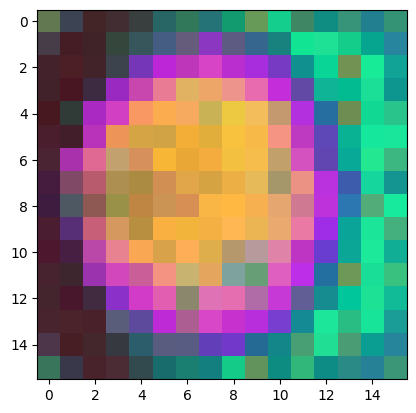

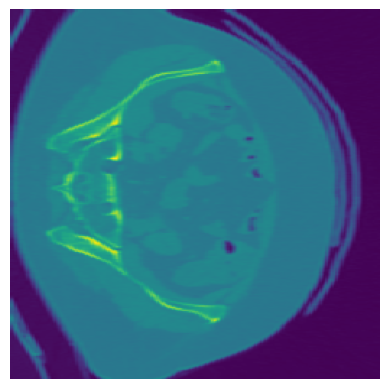

In [16]:
##EVerything below is related to Kmeans, trying to see the effectiveness of the features

import torchvision.transforms as transforms
import torchvision.transforms.functional as F

#PCA visualization, to see if features are good
print(data_train_2_features[0].shape)
b_patch_features = data_train_2_features[0][1]
pca = PCA(n_components=3)
pca_features = pca.fit_transform(b_patch_features.squeeze(0).cpu().numpy())

# Normalize PCA features for visualization
pca_features = (pca_features - pca_features.min()) / (pca_features.max() - pca_features.min())
pca_features = (pca_features * 255).astype(np.uint8)

# Visualize the extracted features as an image
plt.imshow(pca_features.reshape(16, 16, 3))
plt.show()
plt.axis("off")
plt.savefig('meta_dog_features.png')
plt.imshow(data_train[0])

## PUT EVERYTHING IN DATALOADER

In [17]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [18]:
print(f"X_train shape: {data_train.shape}")
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


In [19]:
data_train_1_tensor_features = torch.cat(data_train_1_features, dim=0).cpu()
data_train_2_tensor_features = torch.cat(data_train_2_features, dim=0).cpu()
data_test_tensor_features = torch.cat(data_test_features, dim=0).cpu()
data_val_tensor_features = torch.cat(data_val_features, dim=0).cpu()

torch.cuda.empty_cache() #Clean cuda memory (the model take a lot of place)

# Vérifier les dimensions
print("Train 1 features shape:", data_train_1_tensor_features.shape)
print("Train 2 features shape:", data_train_2_tensor_features.shape)
print("Test features shape:", data_test_tensor_features.shape)
print("Validation features shape:", data_val_tensor_features.shape)

Train 1 features shape: torch.Size([350, 256, 768])
Train 2 features shape: torch.Size([350, 256, 768])
Test features shape: torch.Size([500, 256, 768])
Validation features shape: torch.Size([100, 256, 768])


In [20]:
#patch_features = torch.load("all_patch_features.pth")

#features = torch.cat(patch_features, dim=0)

#print("Features shape:", features.shape)    

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

class MedicalSegDataset(Dataset):
    def __init__(self, images, labels=None, patch_features_tensor=None, is_test=False):
        # Convertir en numpy si c'est un DataFrame Pandas
        if isinstance(images, pd.DataFrame):
            images = images.to_numpy()
        if isinstance(labels, pd.DataFrame) and labels is not None:
            labels = labels.to_numpy()

        self.images = images
        self.labels = labels
        self.patch_features_tensor = patch_features_tensor  # Tenseur de taille (2000, 256, 384)
        self.is_test = is_test  # Indicateur pour savoir si on est en phase de test

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Charger l'image
        image = torch.tensor(self.images[idx], dtype=torch.float32).unsqueeze(0)  # (1, 256, 256)

        # Charger les patch_features
        patch_feature = self.patch_features_tensor[idx]  # (256, 384)
        patch_feature = patch_feature.reshape(16, 16, 768).permute(2, 0, 1)  # (384, 16, 16)

        if self.is_test:
            # En phase de test, on ne retourne pas les labels
            return image, patch_feature
        else:
            # En phase d'entraînement, on retourne les labels
            label = torch.tensor(self.labels[idx], dtype=torch.long).view(256, 256)  # (256, 256)
            return image, label, patch_feature


test_dataset = MedicalSegDataset(data_test, patch_features_tensor=data_test_tensor_features, is_test=True)  

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Inspection du test_loader
for batch_idx, batch_data in enumerate(test_loader):
    image, feature = batch_data  

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

val_dataset = MedicalSegDataset(data_val, label_val, data_val_tensor_features)  # Utiliser 100 images pour la validation

val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# 📌 Création des datasets
train_dataset_1 = MedicalSegDataset(data_train_1, label_train_1, data_train_1_tensor_features)  # Utiliser 600 images pour l'entraînement
train_dataset_2 = MedicalSegDataset(data_train_2,label_train_2, data_train_2_tensor_features)  # Utiliser 200 images pour la validation

train_loader_1 = DataLoader(train_dataset_1, batch_size=8, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=8, shuffle=False)



# Inspect train_loader
for batch_idx, batch_data in enumerate(train_loader_1):
    image, label, feature = batch_data  

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Label shape: {label.shape}, dtype: {label.dtype}, device: {label.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

# Inspect val_loader
for batch_idx, batch_data in enumerate(train_loader_2):
    image, label, feature = batch_data  

    print(f"Batch {batch_idx + 1}:")
    print(f"  Image shape: {image.shape}, dtype: {image.dtype}, device: {image.device}")
    print(f"  Label shape: {label.shape}, dtype: {label.dtype}, device: {label.device}")
    print(f"  Feature shape: {feature.shape}, dtype: {feature.dtype}, device: {feature.device}")

    if batch_idx >= 2:
        break

Batch 1:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 2:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 3:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 1:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Label shape: torch.Size([8, 256, 256]), dtype: torch.int64, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 2:
  Image shape: torch.Size([8, 1, 256, 256]), dtype: torch.float32, device: cpu
  Label shape: torch.Size([8, 256, 256]), dtype: torch.int64, device: cpu
  Feature shape: torch.Size([8, 768, 16, 16]), dtype: torch.float32, device: cpu
Batch 3

In [22]:
class DiceLoss(nn.Module):
    def __init__(self, n_classes):
        super(DiceLoss, self).__init__()
        self.n_classes = n_classes

    def _one_hot_encoder(self, input_tensor):
        tensor_list = []
        for i in range(self.n_classes):
            temp_prob = input_tensor == i  # * torch.ones_like(input_tensor)
            tensor_list.append(temp_prob.unsqueeze(1))
        output_tensor = torch.cat(tensor_list, dim=1)
        return output_tensor.float()

    def _dice_loss(self, score, target):
        target = target.float()
        smooth = 1e-5
        intersect = torch.sum(score * target)
        y_sum = torch.sum(target * target)
        z_sum = torch.sum(score * score)
        loss = (2 * intersect + smooth) / (z_sum + y_sum + smooth)
        loss = 1 - loss
        return loss

    def forward(self, inputs, target, weight=None, softmax=False):
        if softmax:
            inputs = torch.softmax(inputs, dim=1)
        target = self._one_hot_encoder(target)
        if weight is None:
            weight = [1] * self.n_classes
        assert inputs.size() == target.size(), 'predict {} & target {} shape do not match'.format(inputs.size(), target.size())
        class_wise_dice = []
        loss = 0.0
        for i in range(0, self.n_classes):
            dice = self._dice_loss(inputs[:, i], target[:, i])
            class_wise_dice.append(1.0 - dice.item())
            loss += dice * weight[i]
        return loss / self.n_classes


## MODEL WITH ONLY IMAGES

In [22]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model_swin_both = SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_swin_both.parameters(), lr=0.0005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 80  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_swin_both.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_swin_both(images)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_swin_both.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in train_loader_2:
            images, labels = images.to(device), labels.to(device)

            # Passer les images dans le modèle
            outputs = model_swin_both(images)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(train_loader_2)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_swin_both.state_dict(), "best_model_vanilla.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break



C:\Users\yanni\AppData\Local\Temp\ipykernel_13688\1600858977.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [1/80], Loss: 1.8226


  1%|▏         | 1/80 [01:08<1:29:49, 68.22s/it]

Validation Loss: 0.9835
Epoch [2/80], Loss: 1.3677


  2%|▎         | 2/80 [02:16<1:28:33, 68.12s/it]

Validation Loss: 0.9767
Epoch [3/80], Loss: 1.0689


  4%|▍         | 3/80 [03:24<1:27:26, 68.13s/it]

Validation Loss: 0.9726
Epoch [4/80], Loss: 0.9188


  5%|▌         | 4/80 [04:32<1:26:21, 68.18s/it]

Validation Loss: 0.9680
Epoch [5/80], Loss: 0.8626


  6%|▋         | 5/80 [05:40<1:25:16, 68.22s/it]

Validation Loss: 0.9652
Epoch [6/80], Loss: 0.8319


  8%|▊         | 6/80 [06:49<1:24:09, 68.24s/it]

Validation Loss: 0.9627
Epoch [7/80], Loss: 0.8124


  9%|▉         | 7/80 [07:58<1:23:15, 68.43s/it]

Validation Loss: 0.9579
Epoch [8/80], Loss: 0.7927


 10%|█         | 8/80 [09:06<1:22:04, 68.39s/it]

Validation Loss: 0.9534
Epoch [9/80], Loss: 0.7777


 11%|█▏        | 9/80 [10:14<1:20:52, 68.35s/it]

Validation Loss: 0.9512
Epoch [10/80], Loss: 0.7680


 12%|█▎        | 10/80 [11:22<1:19:44, 68.34s/it]

Validation Loss: 0.9447
Epoch [11/80], Loss: 0.7528


 14%|█▍        | 11/80 [12:31<1:18:34, 68.32s/it]

Validation Loss: 0.9342
Epoch [12/80], Loss: 0.7401


 15%|█▌        | 12/80 [13:39<1:17:25, 68.31s/it]

Validation Loss: 0.9266
Epoch [13/80], Loss: 0.7300


 16%|█▋        | 13/80 [14:47<1:16:14, 68.28s/it]

Validation Loss: 0.9202
Epoch [14/80], Loss: 0.7177


 18%|█▊        | 14/80 [15:56<1:15:09, 68.33s/it]

Validation Loss: 0.9101
Epoch [15/80], Loss: 0.7093


 19%|█▉        | 15/80 [17:04<1:14:00, 68.31s/it]

Validation Loss: 0.9032
Epoch [16/80], Loss: 0.7034


 20%|██        | 16/80 [18:12<1:12:52, 68.32s/it]

Validation Loss: 0.8995
Epoch [17/80], Loss: 0.6968


 21%|██▏       | 17/80 [19:21<1:11:43, 68.31s/it]

Validation Loss: 0.9037
Epoch [18/80], Loss: 0.6913


 22%|██▎       | 18/80 [20:29<1:10:34, 68.31s/it]

Validation Loss: 0.8985
Epoch [19/80], Loss: 0.6834


 24%|██▍       | 19/80 [21:37<1:09:27, 68.32s/it]

Validation Loss: 0.8935
Epoch [20/80], Loss: 0.6868


 25%|██▌       | 20/80 [22:46<1:08:21, 68.36s/it]

Validation Loss: 0.8935
Epoch [21/80], Loss: 0.6778


 26%|██▋       | 21/80 [23:54<1:07:16, 68.41s/it]

Validation Loss: 0.8848
Epoch [22/80], Loss: 0.6737


 28%|██▊       | 22/80 [25:03<1:06:07, 68.41s/it]

Validation Loss: 0.8810
Epoch [23/80], Loss: 0.6674


 29%|██▉       | 23/80 [26:11<1:04:55, 68.34s/it]

Validation Loss: 0.8826
Epoch [24/80], Loss: 0.6624


 30%|███       | 24/80 [27:19<1:03:46, 68.33s/it]

Validation Loss: 0.8801
Epoch [25/80], Loss: 0.6573


 31%|███▏      | 25/80 [28:27<1:02:38, 68.33s/it]

Validation Loss: 0.8729
Epoch [26/80], Loss: 0.6529


 32%|███▎      | 26/80 [29:36<1:01:31, 68.37s/it]

Validation Loss: 0.8673
Epoch [27/80], Loss: 0.6425


 34%|███▍      | 27/80 [30:45<1:00:29, 68.47s/it]

Validation Loss: 0.8584
Epoch [28/80], Loss: 0.6371


 35%|███▌      | 28/80 [31:53<59:17, 68.42s/it]  

Validation Loss: 0.8476
Epoch [29/80], Loss: 0.6266


 36%|███▋      | 29/80 [33:01<58:07, 68.38s/it]

Validation Loss: 0.8494
Epoch [30/80], Loss: 0.6244


 38%|███▊      | 30/80 [34:10<57:00, 68.42s/it]

Validation Loss: 0.8408
Epoch [31/80], Loss: 0.6219


 39%|███▉      | 31/80 [35:18<55:51, 68.39s/it]

Validation Loss: 0.8383
Epoch [32/80], Loss: 0.6171


 40%|████      | 32/80 [36:26<54:41, 68.35s/it]

Validation Loss: 0.8359
Epoch [33/80], Loss: 0.6119


 41%|████▏     | 33/80 [37:35<53:34, 68.39s/it]

Validation Loss: 0.8325
Epoch [34/80], Loss: 0.6040


 42%|████▎     | 34/80 [38:43<52:25, 68.37s/it]

Validation Loss: 0.8206
Epoch [35/80], Loss: 0.5980


 44%|████▍     | 35/80 [39:51<51:17, 68.39s/it]

Validation Loss: 0.8148
Epoch [36/80], Loss: 0.5894


 45%|████▌     | 36/80 [41:00<50:09, 68.41s/it]

Validation Loss: 0.8129
Epoch [37/80], Loss: 0.5858


 46%|████▋     | 37/80 [42:08<49:01, 68.40s/it]

Validation Loss: 0.8097
Epoch [38/80], Loss: 0.5771


 48%|████▊     | 38/80 [43:17<47:54, 68.43s/it]

Validation Loss: 0.7927
Epoch [39/80], Loss: 0.5715


 49%|████▉     | 39/80 [44:25<46:43, 68.39s/it]

Validation Loss: 0.7880
Epoch [40/80], Loss: 0.5662


 50%|█████     | 40/80 [45:34<45:38, 68.46s/it]

Validation Loss: 0.7854
Epoch [41/80], Loss: 0.5623


 51%|█████▏    | 41/80 [46:42<44:29, 68.44s/it]

Validation Loss: 0.7815
Epoch [42/80], Loss: 0.5580


 52%|█████▎    | 42/80 [47:51<43:20, 68.43s/it]

Validation Loss: 0.7787
Epoch [43/80], Loss: 0.5538


 54%|█████▍    | 43/80 [48:59<42:11, 68.41s/it]

Validation Loss: 0.7825
Epoch [44/80], Loss: 0.5504


 55%|█████▌    | 44/80 [50:07<41:03, 68.42s/it]

Validation Loss: 0.7786
Epoch [45/80], Loss: 0.5470


 56%|█████▋    | 45/80 [51:16<39:55, 68.44s/it]

Validation Loss: 0.7756
Epoch [46/80], Loss: 0.5428


 57%|█████▊    | 46/80 [52:24<38:47, 68.44s/it]

Validation Loss: 0.7703
Epoch [47/80], Loss: 0.5363


 59%|█████▉    | 47/80 [53:33<37:38, 68.44s/it]

Validation Loss: 0.7701
Epoch [48/80], Loss: 0.5340


 60%|██████    | 48/80 [54:41<36:31, 68.50s/it]

Validation Loss: 0.7698
Epoch [49/80], Loss: 0.5320


 61%|██████▏   | 49/80 [55:50<35:25, 68.57s/it]

Validation Loss: 0.7703
Epoch [50/80], Loss: 0.5305


 62%|██████▎   | 50/80 [56:59<34:20, 68.69s/it]

Validation Loss: 0.7719
Epoch [51/80], Loss: 0.5258


 64%|██████▍   | 51/80 [58:08<33:12, 68.72s/it]

Validation Loss: 0.7707
Epoch [52/80], Loss: 0.5261


 65%|██████▌   | 52/80 [59:17<32:06, 68.81s/it]

Validation Loss: 0.7667
Epoch [53/80], Loss: 0.5165


 66%|██████▋   | 53/80 [1:00:26<31:00, 68.89s/it]

Validation Loss: 0.7652
Epoch [54/80], Loss: 0.4993


 68%|██████▊   | 54/80 [1:01:35<29:52, 68.94s/it]

Validation Loss: 0.7393
Epoch [55/80], Loss: 0.4929


 69%|██████▉   | 55/80 [1:02:44<28:44, 68.99s/it]

Validation Loss: 0.7417
Epoch [56/80], Loss: 0.4920


 70%|███████   | 56/80 [1:03:53<27:35, 68.98s/it]

Validation Loss: 0.7385
Epoch [57/80], Loss: 0.4916


 71%|███████▏  | 57/80 [1:05:02<26:26, 68.97s/it]

Validation Loss: 0.7361
Epoch [58/80], Loss: 0.4861


 72%|███████▎  | 58/80 [1:06:11<25:14, 68.85s/it]

Validation Loss: 0.7417
Epoch [59/80], Loss: 0.4833


 74%|███████▍  | 59/80 [1:07:19<24:03, 68.72s/it]

Validation Loss: 0.7330
Epoch [60/80], Loss: 0.4768


 75%|███████▌  | 60/80 [1:08:27<22:51, 68.58s/it]

Validation Loss: 0.7407
Epoch [61/80], Loss: 0.4766


 76%|███████▋  | 61/80 [1:09:36<21:42, 68.56s/it]

Validation Loss: 0.7396
Epoch [62/80], Loss: 0.4751


 78%|███████▊  | 62/80 [1:10:44<20:32, 68.47s/it]

Validation Loss: 0.7321
Epoch [63/80], Loss: 0.4711


 79%|███████▉  | 63/80 [1:11:52<19:23, 68.43s/it]

Validation Loss: 0.7367
Epoch [64/80], Loss: 0.4696


 80%|████████  | 64/80 [1:13:01<18:15, 68.47s/it]

Validation Loss: 0.7363
Epoch [65/80], Loss: 0.4675


 81%|████████▏ | 65/80 [1:14:09<17:07, 68.47s/it]

Validation Loss: 0.7371
Epoch [66/80], Loss: 0.4605


 82%|████████▎ | 66/80 [1:15:18<15:58, 68.43s/it]

Validation Loss: 0.7392
Epoch [67/80], Loss: 0.4617


 84%|████████▍ | 67/80 [1:16:26<14:48, 68.37s/it]

Validation Loss: 0.7378
Epoch [68/80], Loss: 0.4562


 85%|████████▌ | 68/80 [1:17:34<13:39, 68.32s/it]

Validation Loss: 0.7392
Epoch [69/80], Loss: 0.4562


 86%|████████▋ | 69/80 [1:18:43<12:31, 68.33s/it]

Validation Loss: 0.7377
Epoch [70/80], Loss: 0.4474


 88%|████████▊ | 70/80 [1:19:51<11:23, 68.39s/it]

Validation Loss: 0.7419
Epoch [71/80], Loss: 0.4468


 89%|████████▉ | 71/80 [1:21:00<10:16, 68.47s/it]

Validation Loss: 0.7384
Epoch [72/80], Loss: 0.4472


 89%|████████▉ | 71/80 [1:22:08<10:24, 69.42s/it]

Validation Loss: 0.7488
Arrêt prématuré à l'époque 72


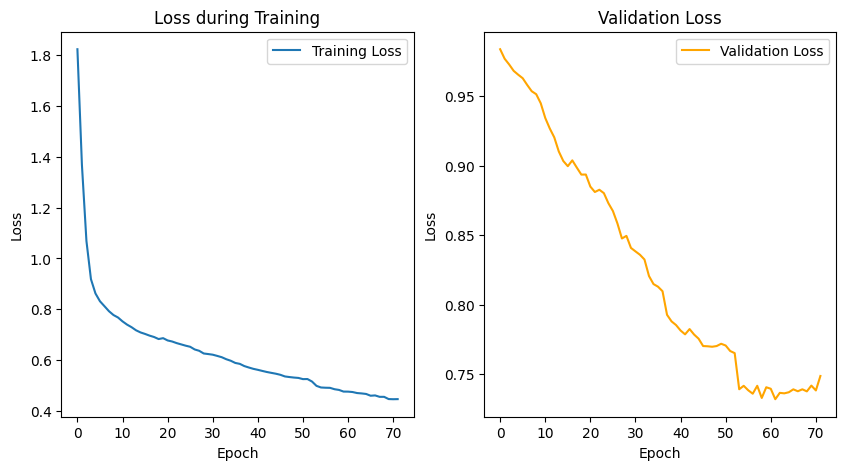

In [ ]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [28]:
model_swin_both.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in (train_loader_2):
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_swin_both(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score_both = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score_both:.4f}")

Validation Dice Score: 0.1567


C:\Users\yanni\AppData\Local\Temp\ipykernel_13688\1039583736.py:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


In [21]:
torch.save(model_swin_both.state_dict(), 'best_model_vanilla.pth')
torch.cuda.empty_cache()

In [29]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recréer le modèle avec la même architecture
best_model = SwinUNETR(
    img_size=(256, 256),  
    in_channels=1,  
    out_channels=NUM_CLASSES+1,  
    use_checkpoint=True,  
    spatial_dims=2,  
).to(device)

# Charger les poids
best_model.load_state_dict(torch.load("best_model_vanilla.pth"))
best_model.eval()


c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
C:\Users\yanni\AppData\Local\Temp\ipykernel_13688\826496867.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 24, kernel_size=(2, 2), stride=(2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=24, out_features=72, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=24, out_features=24, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=24, out_features=96, bias=True)
              (linear2): Linear(in_features=96, ou

In [30]:
best_model.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = best_model(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.1739


C:\Users\yanni\AppData\Local\Temp\ipykernel_13688\1039583736.py:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


In [31]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images = images.to(device)
            outputs = model(images)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(best_model, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")


Generating predictions: 100%|██████████| 63/63 [00:11<00:00,  5.49it/s]


Predictions shape: (500, 256, 256)
CSV file saved successfully!


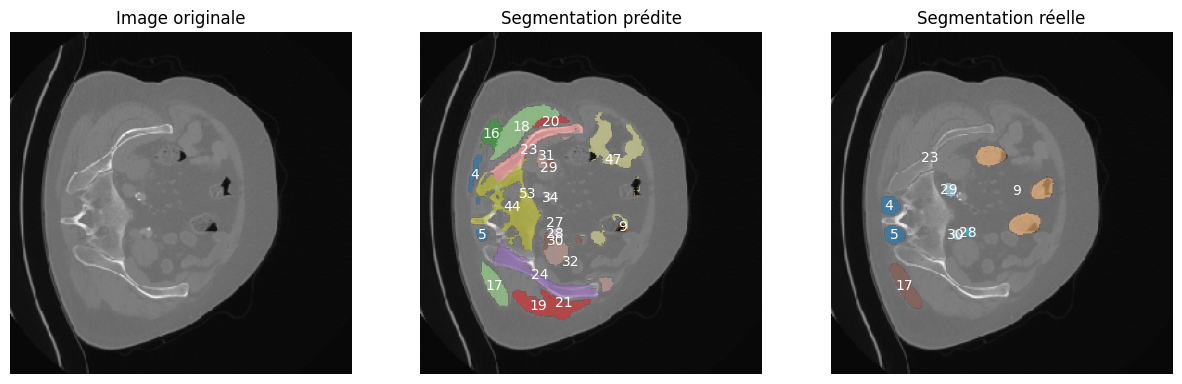

In [ ]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(train_dataset_2)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = train_dataset_2[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = best_model(image)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)

In [24]:
torch.cuda.empty_cache()

## MODEL WITH IMAGES AND FEATURES

In [ ]:
import torch
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model = SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)



c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SwinUNETR  # Assurez-vous d'importer le bon module

class SwinUNETRWithFeatures(nn.Module):
    def __init__(self, 
                 img_size=(256, 256), 
                 in_channels=1, 
                 out_channels=NUM_CLASSES+1,
                 pretrained_model=None):
        super(SwinUNETRWithFeatures, self).__init__()
        
        # Backbone SwinUNETR pré-entraîné
        self.swin_unetr = SwinUNETR(
            img_size=img_size,
            in_channels=in_channels,
            out_channels=out_channels,
            use_checkpoint=True,
            spatial_dims=2
        )
        
        if pretrained_model is not None:
            # Charger les poids pré-entraînés dans le backbone
            self.swin_unetr.load_state_dict(pretrained_model, strict=False)
        
        # Branch pour traiter les patch features
        # Ici on suppose que les patch features sont de taille (384, 16, 16)
        # On peut par exemple les transformer pour obtenir une carte de dimension (C, H, W)
        # afin de les fusionner avec le decoder (ou directement dans le head)
        self.features_conv = nn.Sequential(
            nn.Conv2d(768, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Module de fusion (par exemple, concaténer les deux cartes et les traiter)
        # On suppose que la sortie du SwinUNETR est de taille (B, out_channels, H, W)
        # et que l'on veut fusionner la branche features après une redimension
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(out_channels + 64, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, image, patch_feature):
        # Passage dans le modèle de base
        seg_out = self.swin_unetr(image)  # sortie de taille (B, out_channels, H, W)
        
        # Traitement des patch features
        # patch_feature: (B, 384, 16, 16)
        features = self.features_conv(patch_feature)  # -> (B, 64, 16, 16)
        
        # Si nécessaire, redimensionner la carte de features pour qu'elle ait la même taille que seg_out
        # On utilise ici une interpolation bilinéaire
        features_upsampled = F.interpolate(features, size=seg_out.shape[2:], mode='bilinear', align_corners=False)
        
        # Fusionner les deux features (concaténation sur la dimension des canaux)
        fused = torch.cat([seg_out, features_upsampled], dim=1)
        out = self.fusion_conv(fused)
        
        return out


In [28]:

# Créez une instance de votre nouveau modèle en passant les poids pré-entraînés
model_with_features = SwinUNETRWithFeatures(
    img_size=(256, 256), 
    in_channels=1, 
    out_channels=NUM_CLASSES+1, 
).to(device)


In [31]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_with_features.parameters(), lr=0.0005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 80  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_with_features.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model_with_features(images, features)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_with_features.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in train_loader_2:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_with_features(images, features)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(train_loader_2)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_with_features.state_dict(), "best_model_with_features.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break

C:\Users\yanni\AppData\Local\Temp\ipykernel_4488\2795139198.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/80 [00:00<?, ?it/s]

Epoch [1/80], Loss: 1.8758


  1%|▏         | 1/80 [01:23<1:49:41, 83.31s/it]

Validation Loss: 0.8759
Epoch [2/80], Loss: 1.8154


  2%|▎         | 2/80 [02:45<1:47:36, 82.77s/it]

Validation Loss: 0.8585
Epoch [3/80], Loss: 1.7710


  4%|▍         | 3/80 [04:08<1:45:56, 82.56s/it]

Validation Loss: 0.8620
Epoch [4/80], Loss: 1.7386


  5%|▌         | 4/80 [05:30<1:44:27, 82.46s/it]

Validation Loss: 0.8622
Epoch [5/80], Loss: 1.7092


  6%|▋         | 5/80 [06:52<1:42:57, 82.37s/it]

Validation Loss: 0.8502
Epoch [6/80], Loss: 1.6741


  8%|▊         | 6/80 [08:14<1:41:32, 82.33s/it]

Validation Loss: 0.8524
Epoch [7/80], Loss: 1.6483


  9%|▉         | 7/80 [09:37<1:40:08, 82.31s/it]

Validation Loss: 0.8441
Epoch [8/80], Loss: 1.6149


 10%|█         | 8/80 [10:59<1:38:58, 82.48s/it]

Validation Loss: 0.8499
Epoch [9/80], Loss: 1.5930


 11%|█▏        | 9/80 [12:22<1:37:29, 82.39s/it]

Validation Loss: 0.8525
Epoch [10/80], Loss: 1.5622


 12%|█▎        | 10/80 [13:44<1:36:11, 82.45s/it]

Validation Loss: 0.8577
Epoch [11/80], Loss: 1.5410


 14%|█▍        | 11/80 [15:07<1:34:54, 82.53s/it]

Validation Loss: 0.8542
Epoch [12/80], Loss: 1.5123


 15%|█▌        | 12/80 [16:29<1:33:30, 82.51s/it]

Validation Loss: 0.8499
Epoch [13/80], Loss: 1.4894


 16%|█▋        | 13/80 [17:52<1:32:08, 82.51s/it]

Validation Loss: 0.8506
Epoch [14/80], Loss: 1.4662


 18%|█▊        | 14/80 [19:14<1:30:42, 82.47s/it]

Validation Loss: 0.8440
Epoch [15/80], Loss: 1.4426


 19%|█▉        | 15/80 [20:37<1:29:18, 82.43s/it]

Validation Loss: 0.8489
Epoch [16/80], Loss: 1.4157


 20%|██        | 16/80 [21:59<1:27:54, 82.41s/it]

Validation Loss: 0.8463
Epoch [17/80], Loss: 1.3948


 21%|██▏       | 17/80 [23:21<1:26:29, 82.37s/it]

Validation Loss: 0.8435
Epoch [18/80], Loss: 1.3727


 22%|██▎       | 18/80 [24:43<1:25:04, 82.34s/it]

Validation Loss: 0.8607
Epoch [19/80], Loss: 1.3461


 24%|██▍       | 19/80 [26:06<1:23:41, 82.33s/it]

Validation Loss: 0.8429
Epoch [20/80], Loss: 1.3290


 25%|██▌       | 20/80 [27:28<1:22:18, 82.31s/it]

Validation Loss: 0.8493
Epoch [21/80], Loss: 1.3091


 26%|██▋       | 21/80 [28:51<1:21:01, 82.39s/it]

Validation Loss: 0.8526
Epoch [22/80], Loss: 1.2885


 28%|██▊       | 22/80 [30:13<1:19:36, 82.35s/it]

Validation Loss: 0.8585
Epoch [23/80], Loss: 1.2644


 29%|██▉       | 23/80 [31:35<1:18:12, 82.33s/it]

Validation Loss: 0.8539
Epoch [24/80], Loss: 1.2437


 30%|███       | 24/80 [32:57<1:16:49, 82.31s/it]

Validation Loss: 0.8409
Epoch [25/80], Loss: 1.2242


 31%|███▏      | 25/80 [34:20<1:15:26, 82.29s/it]

Validation Loss: 0.8416
Epoch [26/80], Loss: 1.2010


 32%|███▎      | 26/80 [35:42<1:14:03, 82.29s/it]

Validation Loss: 0.8525
Epoch [27/80], Loss: 1.1839


 34%|███▍      | 27/80 [37:04<1:12:41, 82.30s/it]

Validation Loss: 0.8432
Epoch [28/80], Loss: 1.1599


 35%|███▌      | 28/80 [38:27<1:11:18, 82.28s/it]

Validation Loss: 0.8459
Epoch [29/80], Loss: 1.1439


 36%|███▋      | 29/80 [39:49<1:09:55, 82.26s/it]

Validation Loss: 0.8471
Epoch [30/80], Loss: 1.1252


 38%|███▊      | 30/80 [41:11<1:08:35, 82.32s/it]

Validation Loss: 0.8416
Epoch [31/80], Loss: 1.1018


 39%|███▉      | 31/80 [42:33<1:07:13, 82.31s/it]

Validation Loss: 0.8423
Epoch [32/80], Loss: 1.0908


 40%|████      | 32/80 [43:56<1:05:50, 82.30s/it]

Validation Loss: 0.8444
Epoch [33/80], Loss: 1.0697


 41%|████▏     | 33/80 [45:18<1:04:27, 82.30s/it]

Validation Loss: 0.8407
Epoch [34/80], Loss: 1.0541


 42%|████▎     | 34/80 [46:40<1:03:05, 82.28s/it]

Validation Loss: 0.8511
Epoch [35/80], Loss: 1.0293


 44%|████▍     | 35/80 [48:02<1:01:41, 82.26s/it]

Validation Loss: 0.8457
Epoch [36/80], Loss: 1.0177


 45%|████▌     | 36/80 [49:25<1:00:21, 82.30s/it]

Validation Loss: 0.8420
Epoch [37/80], Loss: 0.9992


 46%|████▋     | 37/80 [50:47<58:58, 82.29s/it]  

Validation Loss: 0.8341
Epoch [38/80], Loss: 0.9892


 48%|████▊     | 38/80 [52:09<57:35, 82.26s/it]

Validation Loss: 0.8350
Epoch [39/80], Loss: 0.9708


 49%|████▉     | 39/80 [53:32<56:12, 82.25s/it]

Validation Loss: 0.8429
Epoch [40/80], Loss: 0.9568


 50%|█████     | 40/80 [54:54<54:50, 82.27s/it]

Validation Loss: 0.8380
Epoch [41/80], Loss: 0.9352


 51%|█████▏    | 41/80 [56:16<53:28, 82.27s/it]

Validation Loss: 0.8435
Epoch [42/80], Loss: 0.9223


 52%|█████▎    | 42/80 [57:38<52:05, 82.25s/it]

Validation Loss: 0.8416
Epoch [43/80], Loss: 0.9068


 54%|█████▍    | 43/80 [59:01<50:44, 82.29s/it]

Validation Loss: 0.8350
Epoch [44/80], Loss: 0.8913


 55%|█████▌    | 44/80 [1:00:23<49:21, 82.27s/it]

Validation Loss: 0.8384
Epoch [45/80], Loss: 0.8810


 56%|█████▋    | 45/80 [1:01:45<47:59, 82.27s/it]

Validation Loss: 0.8350
Epoch [46/80], Loss: 0.8626


 57%|█████▊    | 46/80 [1:03:07<46:36, 82.25s/it]

Validation Loss: 0.8468
Epoch [47/80], Loss: 0.8470


 57%|█████▊    | 46/80 [1:04:30<47:40, 84.13s/it]

Validation Loss: 0.8375
Arrêt prématuré à l'époque 47


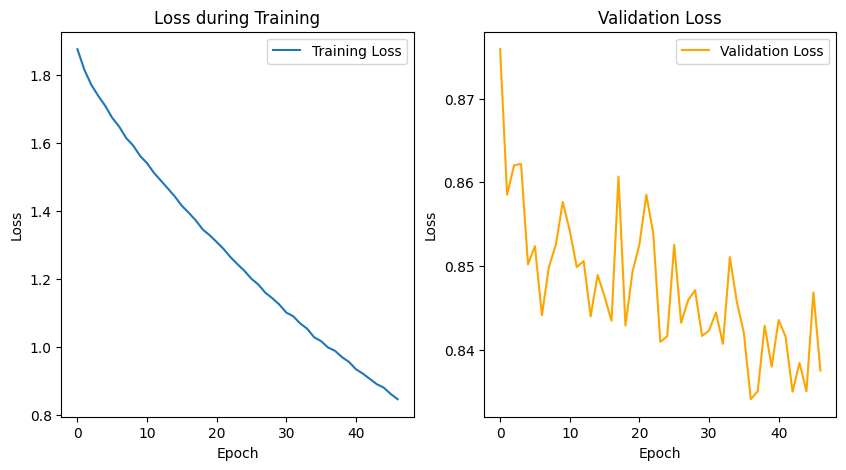

In [33]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [35]:
model_with_features.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_with_features(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.1599


C:\Users\yanni\AppData\Local\Temp\ipykernel_4488\1039583736.py:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


In [36]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images, features = images.to(device), features.to(device)
            outputs = model(images, features)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(model_with_features, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions_with_features.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")

Generating predictions: 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


Predictions shape: (500, 256, 256)
CSV file saved successfully!


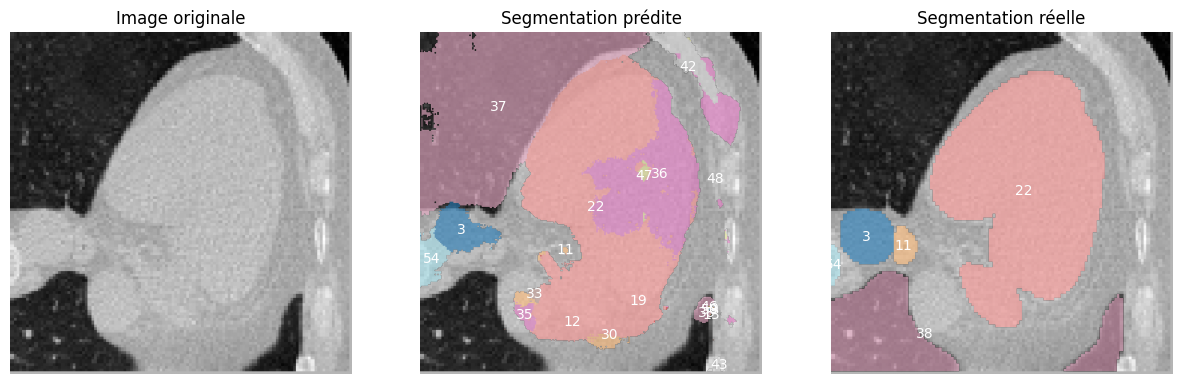

In [39]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(train_dataset_2)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = train_dataset_2[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = model_with_features(image, feature)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)

## MODEL WITH FINE-TUNING 

In [23]:
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model_pre_training= SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

torch.backends.cudnn.benchmark = True
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
optimizer = optim.AdamW(model_pre_training.parameters(), lr=0.0005, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

# Boucle d'entraînement simple
num_epochs = 80  # Ajuste selon tes besoins
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_pre_training.train()
    running_loss = 0.0

    for images, labels, features in train_loader_1:
        images, labels, features = images.to(device), labels.to(device), features

        optimizer.zero_grad()
        outputs = model_pre_training(images, features)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_1))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_1):.4f}")

    # ---- ÉVALUATION ----
    model_pre_training.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_loader:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_pre_training(images, features)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Sauvegarder le modèle si la perte de validation est la meilleure vue jusqu'à présent
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_pre_training.state_dict(), "best_model_pre_training.pth")
        counter = 0
    else:
        counter += 1
    if counter == patience:
        print(f"Arrêt prématuré à l'époque {epoch+1}")
        break

c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
C:\Users\yanni\AppData\Local\Temp\ipykernel_14976\3102911540.py:18: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/80 [00:00<?, ?it/s]


TypeError: SwinUNETR.forward() takes 2 positional arguments but 3 were given

In [ ]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [ ]:
model_pre_training.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_pre_training(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
from monai.networks.nets import SwinUNETR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Change img_size to match the actual image size (256, 256)
model = SwinUNETR(
    img_size=(256, 256),  # Match the actual input image size
    in_channels=1,  # Images CT-scan en niveaux de gris
    out_channels=NUM_CLASSES+1,  # Nombre de classes
    use_checkpoint=True,  # Gradient checkpointing pour économiser la mémoire
    spatial_dims=2,  # Important pour utiliser la version 2D
).to(device)

model.load_state_dict(torch.load('best_model_pre_training.pth', weights_only=True))



c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


<All keys matched successfully>

In [40]:
model.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model(images)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.1296


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SwinUNETR  # Assurez-vous d'importer le bon module

class SwinUNETRWithFeatures(nn.Module):
    def __init__(self, 
                 img_size=(256, 256), 
                 in_channels=1, 
                 out_channels=NUM_CLASSES+1,
                 pretrained_model=None):
        super(SwinUNETRWithFeatures, self).__init__()
        
        # Backbone SwinUNETR pré-entraîné
        self.swin_unetr = SwinUNETR(
            img_size=img_size,
            in_channels=in_channels,
            out_channels=out_channels,
            use_checkpoint=True,
            spatial_dims=2
        )
        
        if pretrained_model is not None:
            # Charger les poids pré-entraînés dans le backbone
            self.swin_unetr.load_state_dict(pretrained_model, strict=False)
        
        # Branch pour traiter les patch features
        # Ici on suppose que les patch features sont de taille (384, 16, 16)
        # On peut par exemple les transformer pour obtenir une carte de dimension (C, H, W)
        # afin de les fusionner avec le decoder (ou directement dans le head)
        self.features_conv = nn.Sequential(
            nn.Conv2d(384, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Module de fusion (par exemple, concaténer les deux cartes et les traiter)
        # On suppose que la sortie du SwinUNETR est de taille (B, out_channels, H, W)
        # et que l'on veut fusionner la branche features après une redimension
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(out_channels + 64, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, image, patch_feature):
        # Passage dans le modèle de base
        seg_out = self.swin_unetr(image)  # sortie de taille (B, out_channels, H, W)
        
        # Traitement des patch features
        # patch_feature: (B, 384, 16, 16)
        features = self.features_conv(patch_feature)  # -> (B, 64, 16, 16)
        
        # Si nécessaire, redimensionner la carte de features pour qu'elle ait la même taille que seg_out
        # On utilise ici une interpolation bilinéaire
        features_upsampled = F.interpolate(features, size=seg_out.shape[2:], mode='bilinear', align_corners=False)
        
        # Fusionner les deux features (concaténation sur la dimension des canaux)
        fused = torch.cat([seg_out, features_upsampled], dim=1)
        out = self.fusion_conv(fused)
        
        return out


In [ ]:
# Supposons que model_swin_both est votre modèle pré-entraîné (instance de SwinUNETR)
pretrained_weights = model.state_dict()

# Créez une instance de votre nouveau modèle en passant les poids pré-entraînés
model_fine_tuning = SwinUNETRWithFeatures(
    img_size=(256, 256), 
    in_channels=1, 
    out_channels=NUM_CLASSES+1, 
    pretrained_model=pretrained_weights
).to(device)


c:\Users\yanni\anaconda3\lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [ ]:
model_fine_tuning.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_fine_tuning(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.0003


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.4273


  1%|          | 1/100 [01:02<1:42:55, 62.38s/it]

Validation Loss: 0.6350
Epoch [2/100], Loss: 0.4073


  2%|▏         | 2/100 [02:04<1:41:10, 61.94s/it]

Validation Loss: 0.6457
Epoch [3/100], Loss: 0.4023


  3%|▎         | 3/100 [03:05<1:39:53, 61.79s/it]

Validation Loss: 0.6537
Epoch [4/100], Loss: 0.3991


  4%|▍         | 4/100 [04:07<1:38:46, 61.74s/it]

Validation Loss: 0.6493
Epoch [5/100], Loss: 0.3990


  5%|▌         | 5/100 [05:08<1:37:42, 61.71s/it]

Validation Loss: 0.6705
Epoch [6/100], Loss: 0.3950


  6%|▌         | 6/100 [06:10<1:36:38, 61.69s/it]

Validation Loss: 0.6671
Epoch [7/100], Loss: 0.4003


  7%|▋         | 7/100 [07:12<1:35:37, 61.69s/it]

Validation Loss: 0.6914
Epoch [8/100], Loss: 0.3979


  8%|▊         | 8/100 [08:14<1:34:47, 61.82s/it]

Validation Loss: 0.6704
Epoch [9/100], Loss: 0.3940


  9%|▉         | 9/100 [09:16<1:33:41, 61.78s/it]

Validation Loss: 0.6699
Epoch [10/100], Loss: 0.3929


 10%|█         | 10/100 [10:17<1:32:36, 61.74s/it]

Validation Loss: 0.6742
Epoch [11/100], Loss: 0.3902


 11%|█         | 11/100 [11:19<1:31:31, 61.70s/it]

Validation Loss: 0.6827
Epoch [12/100], Loss: 0.3881


 12%|█▏        | 12/100 [12:20<1:30:25, 61.66s/it]

Validation Loss: 0.6833
Epoch [13/100], Loss: 0.3898


 13%|█▎        | 13/100 [13:22<1:29:23, 61.65s/it]

Validation Loss: 0.6805
Epoch [14/100], Loss: 0.3884


 14%|█▍        | 14/100 [14:24<1:28:20, 61.63s/it]

Validation Loss: 0.6754
Epoch [15/100], Loss: 0.3828


 15%|█▌        | 15/100 [15:25<1:27:17, 61.62s/it]

Validation Loss: 0.6796
Epoch [16/100], Loss: 0.3803


 16%|█▌        | 16/100 [16:27<1:26:20, 61.67s/it]

Validation Loss: 0.6872
Epoch [17/100], Loss: 0.3742


 17%|█▋        | 17/100 [17:29<1:25:35, 61.87s/it]

Validation Loss: 0.6833
Epoch [18/100], Loss: 0.3652


 18%|█▊        | 18/100 [18:32<1:25:01, 62.22s/it]

Validation Loss: 0.7036
Epoch [19/100], Loss: 0.3588


 19%|█▉        | 19/100 [19:35<1:24:02, 62.25s/it]

Validation Loss: 0.7071
Epoch [20/100], Loss: 0.3512


 20%|██        | 20/100 [20:37<1:22:58, 62.23s/it]

Validation Loss: 0.7048
Epoch [21/100], Loss: 0.3478


 21%|██        | 21/100 [21:39<1:21:52, 62.18s/it]

Validation Loss: 0.6983
Epoch [22/100], Loss: 0.3436


 22%|██▏       | 22/100 [22:41<1:20:39, 62.05s/it]

Validation Loss: 0.7087
Epoch [23/100], Loss: 0.3447


 23%|██▎       | 23/100 [23:42<1:19:30, 61.96s/it]

Validation Loss: 0.7301
Epoch [24/100], Loss: 0.3388


 24%|██▍       | 24/100 [24:44<1:18:29, 61.97s/it]

Validation Loss: 0.7167
Epoch [25/100], Loss: 0.3344


 25%|██▌       | 25/100 [25:46<1:17:20, 61.88s/it]

Validation Loss: 0.7148
Epoch [26/100], Loss: 0.3264


 26%|██▌       | 26/100 [26:48<1:16:15, 61.84s/it]

Validation Loss: 0.7349
Epoch [27/100], Loss: 0.3266


 27%|██▋       | 27/100 [27:50<1:15:11, 61.81s/it]

Validation Loss: 0.7248
Epoch [28/100], Loss: 0.3240


 28%|██▊       | 28/100 [28:51<1:14:12, 61.84s/it]

Validation Loss: 0.7456
Epoch [29/100], Loss: 0.3224


 29%|██▉       | 29/100 [29:54<1:13:29, 62.11s/it]

Validation Loss: 0.7455
Epoch [30/100], Loss: 0.3121


 30%|███       | 30/100 [30:56<1:12:28, 62.12s/it]

Validation Loss: 0.7500
Epoch [31/100], Loss: 0.3061


 31%|███       | 31/100 [31:59<1:11:29, 62.16s/it]

Validation Loss: 0.7493
Epoch [32/100], Loss: 0.3038


 32%|███▏      | 32/100 [33:02<1:10:50, 62.51s/it]

Validation Loss: 0.7411
Epoch [33/100], Loss: 0.3002


 33%|███▎      | 33/100 [34:04<1:09:34, 62.31s/it]

Validation Loss: 0.7525
Epoch [34/100], Loss: 0.3038


 34%|███▍      | 34/100 [35:06<1:08:23, 62.18s/it]

Validation Loss: 0.7743
Epoch [35/100], Loss: 0.3006


 35%|███▌      | 35/100 [36:08<1:07:24, 62.23s/it]

Validation Loss: 0.7772
Epoch [36/100], Loss: 0.2950


 36%|███▌      | 36/100 [37:11<1:06:37, 62.46s/it]

Validation Loss: 0.7699
Epoch [37/100], Loss: 0.2957


 37%|███▋      | 37/100 [38:13<1:05:35, 62.46s/it]

Validation Loss: 0.7741
Epoch [38/100], Loss: 0.2937


 38%|███▊      | 38/100 [39:16<1:04:25, 62.35s/it]

Validation Loss: 0.7618
Epoch [39/100], Loss: 0.2967


 39%|███▉      | 39/100 [40:18<1:03:20, 62.31s/it]

Validation Loss: 0.7497
Epoch [40/100], Loss: 0.2854


 40%|████      | 40/100 [41:21<1:02:29, 62.49s/it]

Validation Loss: 0.7669
Epoch [41/100], Loss: 0.2864


 41%|████      | 41/100 [42:25<1:02:02, 63.10s/it]

Validation Loss: 0.7793
Epoch [42/100], Loss: 0.2850


 42%|████▏     | 42/100 [43:27<1:00:36, 62.70s/it]

Validation Loss: 0.7668
Epoch [43/100], Loss: 0.2849


 43%|████▎     | 43/100 [44:29<59:17, 62.42s/it]  

Validation Loss: 0.7620
Epoch [44/100], Loss: 0.2862


 44%|████▍     | 44/100 [45:30<58:04, 62.22s/it]

Validation Loss: 0.7628
Epoch [45/100], Loss: 0.2837


 45%|████▌     | 45/100 [46:32<56:56, 62.13s/it]

Validation Loss: 0.7832
Epoch [46/100], Loss: 0.2838


 46%|████▌     | 46/100 [47:34<55:49, 62.04s/it]

Validation Loss: 0.7665
Epoch [47/100], Loss: 0.2807


 47%|████▋     | 47/100 [48:36<54:44, 61.98s/it]

Validation Loss: 0.7674
Epoch [48/100], Loss: 0.2786


 48%|████▊     | 48/100 [49:38<53:40, 61.94s/it]

Validation Loss: 0.7739
Epoch [49/100], Loss: 0.2779


 49%|████▉     | 49/100 [50:40<52:36, 61.90s/it]

Validation Loss: 0.7698
Epoch [50/100], Loss: 0.2756


 50%|█████     | 50/100 [51:42<51:39, 61.98s/it]

Validation Loss: 0.7827
Epoch [51/100], Loss: 0.2767


 51%|█████     | 51/100 [52:44<50:36, 61.97s/it]

Validation Loss: 0.7832
Epoch [52/100], Loss: 0.2733


 52%|█████▏    | 52/100 [53:46<49:32, 61.93s/it]

Validation Loss: 0.7837
Epoch [53/100], Loss: 0.2724


 53%|█████▎    | 53/100 [54:48<48:30, 61.93s/it]

Validation Loss: 0.7977
Epoch [54/100], Loss: 0.2736


 54%|█████▍    | 54/100 [55:49<47:27, 61.91s/it]

Validation Loss: 0.7855
Epoch [55/100], Loss: 0.2719


 55%|█████▌    | 55/100 [56:51<46:24, 61.88s/it]

Validation Loss: 0.7795
Epoch [56/100], Loss: 0.2688


 56%|█████▌    | 56/100 [57:53<45:22, 61.88s/it]

Validation Loss: 0.7864
Epoch [57/100], Loss: 0.2702


 57%|█████▋    | 57/100 [58:55<44:23, 61.94s/it]

Validation Loss: 0.8000
Epoch [58/100], Loss: 0.2685


 58%|█████▊    | 58/100 [59:57<43:21, 61.94s/it]

Validation Loss: 0.7825
Epoch [59/100], Loss: 0.2695


 59%|█████▉    | 59/100 [1:00:59<42:18, 61.92s/it]

Validation Loss: 0.7870
Epoch [60/100], Loss: 0.2684


 60%|██████    | 60/100 [1:02:01<41:21, 62.03s/it]

Validation Loss: 0.7875
Epoch [61/100], Loss: 0.2692


 61%|██████    | 61/100 [1:03:03<40:18, 62.01s/it]

Validation Loss: 0.8022
Epoch [62/100], Loss: 0.2736


 62%|██████▏   | 62/100 [1:04:05<39:15, 61.99s/it]

Validation Loss: 0.7912
Epoch [63/100], Loss: 0.2631


 63%|██████▎   | 63/100 [1:05:07<38:13, 61.98s/it]

Validation Loss: 0.8045
Epoch [64/100], Loss: 0.2725


 64%|██████▍   | 64/100 [1:06:09<37:09, 61.94s/it]

Validation Loss: 0.7928
Epoch [65/100], Loss: 0.2638


 65%|██████▌   | 65/100 [1:07:11<36:07, 61.92s/it]

Validation Loss: 0.8073
Epoch [66/100], Loss: 0.2618


 66%|██████▌   | 66/100 [1:08:13<35:04, 61.90s/it]

Validation Loss: 0.7941
Epoch [67/100], Loss: 0.2632


 67%|██████▋   | 67/100 [1:09:15<34:03, 61.92s/it]

Validation Loss: 0.8039
Epoch [68/100], Loss: 0.2714


 68%|██████▊   | 68/100 [1:10:17<33:01, 61.92s/it]

Validation Loss: 0.7767
Epoch [69/100], Loss: 0.2667


 69%|██████▉   | 69/100 [1:11:19<31:59, 61.92s/it]

Validation Loss: 0.8028
Epoch [70/100], Loss: 0.2626


 70%|███████   | 70/100 [1:12:21<30:58, 61.96s/it]

Validation Loss: 0.8015
Epoch [71/100], Loss: 0.2653


 71%|███████   | 71/100 [1:13:23<29:57, 61.98s/it]

Validation Loss: 0.8017
Epoch [72/100], Loss: 0.2551


 72%|███████▏  | 72/100 [1:14:25<28:55, 61.99s/it]

Validation Loss: 0.8183
Epoch [73/100], Loss: 0.2535


 73%|███████▎  | 73/100 [1:15:27<27:53, 61.99s/it]

Validation Loss: 0.8162
Epoch [74/100], Loss: 0.2585


 74%|███████▍  | 74/100 [1:16:29<26:58, 62.23s/it]

Validation Loss: 0.8095
Epoch [75/100], Loss: 0.2529


 75%|███████▌  | 75/100 [1:17:31<25:53, 62.12s/it]

Validation Loss: 0.8124
Epoch [76/100], Loss: 0.2606


 76%|███████▌  | 76/100 [1:18:33<24:49, 62.06s/it]

Validation Loss: 0.8242
Epoch [77/100], Loss: 0.2534


 77%|███████▋  | 77/100 [1:19:35<23:45, 61.99s/it]

Validation Loss: 0.8206
Epoch [78/100], Loss: 0.2569


 78%|███████▊  | 78/100 [1:20:37<22:42, 61.95s/it]

Validation Loss: 0.8300
Epoch [79/100], Loss: 0.2572


 79%|███████▉  | 79/100 [1:21:39<21:39, 61.90s/it]

Validation Loss: 0.8236
Epoch [80/100], Loss: 0.2564


 80%|████████  | 80/100 [1:22:41<20:38, 61.93s/it]

Validation Loss: 0.8263
Epoch [81/100], Loss: 0.2535


 81%|████████  | 81/100 [1:23:43<19:36, 61.91s/it]

Validation Loss: 0.8271
Epoch [82/100], Loss: 0.2546


 82%|████████▏ | 82/100 [1:24:44<18:34, 61.90s/it]

Validation Loss: 0.8399
Epoch [83/100], Loss: 0.2529


 83%|████████▎ | 83/100 [1:25:47<17:36, 62.12s/it]

Validation Loss: 0.8418
Epoch [84/100], Loss: 0.2570


 84%|████████▍ | 84/100 [1:26:49<16:33, 62.08s/it]

Validation Loss: 0.8283
Epoch [85/100], Loss: 0.2532


 85%|████████▌ | 85/100 [1:27:51<15:30, 62.06s/it]

Validation Loss: 0.8358
Epoch [86/100], Loss: 0.2526


 86%|████████▌ | 86/100 [1:28:53<14:27, 61.99s/it]

Validation Loss: 0.8448
Epoch [87/100], Loss: 0.2561


 87%|████████▋ | 87/100 [1:29:55<13:24, 61.92s/it]

Validation Loss: 0.8361
Epoch [88/100], Loss: 0.2513


 88%|████████▊ | 88/100 [1:30:56<12:22, 61.87s/it]

Validation Loss: 0.8421
Epoch [89/100], Loss: 0.2561


 89%|████████▉ | 89/100 [1:31:58<11:20, 61.83s/it]

Validation Loss: 0.8474
Epoch [90/100], Loss: 0.2556


 90%|█████████ | 90/100 [1:33:00<10:18, 61.88s/it]

Validation Loss: 0.8323
Epoch [91/100], Loss: 0.2606


 91%|█████████ | 91/100 [1:34:02<09:16, 61.83s/it]

Validation Loss: 0.8421
Epoch [92/100], Loss: 0.2578


 92%|█████████▏| 92/100 [1:35:04<08:14, 61.84s/it]

Validation Loss: 0.8508
Epoch [93/100], Loss: 0.2580


 93%|█████████▎| 93/100 [1:36:06<07:13, 61.93s/it]

Validation Loss: 0.8382
Epoch [94/100], Loss: 0.2564


 94%|█████████▍| 94/100 [1:37:08<06:11, 61.92s/it]

Validation Loss: 0.8315
Epoch [95/100], Loss: 0.2549


 95%|█████████▌| 95/100 [1:38:10<05:09, 61.90s/it]

Validation Loss: 0.8450
Epoch [96/100], Loss: 0.2524


 96%|█████████▌| 96/100 [1:39:11<04:07, 61.88s/it]

Validation Loss: 0.8355
Epoch [97/100], Loss: 0.2562


 97%|█████████▋| 97/100 [1:40:13<03:05, 61.88s/it]

Validation Loss: 0.8434
Epoch [98/100], Loss: 0.2598


 98%|█████████▊| 98/100 [1:41:15<02:03, 61.84s/it]

Validation Loss: 0.8533
Epoch [99/100], Loss: 0.2618


 99%|█████████▉| 99/100 [1:42:17<01:01, 61.79s/it]

Validation Loss: 0.8449
Epoch [100/100], Loss: 0.2579


100%|██████████| 100/100 [1:43:18<00:00, 61.99s/it]

Validation Loss: 0.8447


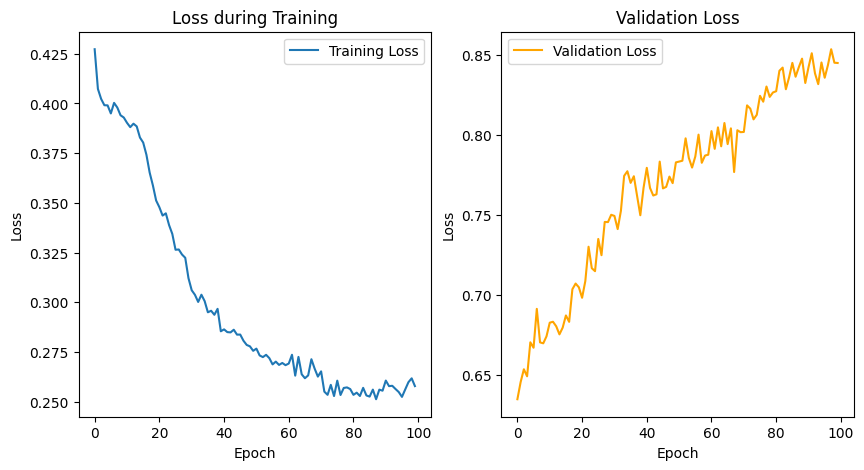

In [ ]:
# Fine-tune the model
optimizer = optim.AdamW(model_fine_tuning.parameters(), lr=1e-4, weight_decay=1e-5)
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss(NUM_CLASSES+1)
num_epochs = 100
losses = []
val_losses = []
counter = 0  # Compteur d'époques sans amélioration
patience = 10  # Nombre d'époques sans amélioration avant d'arrêter
best_val_loss = float('inf')

for epoch in tqdm(range(num_epochs)):
    model_fine_tuning.train()
    running_loss = 0.0

    for images, labels, features in train_loader_2:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model_fine_tuning(images, features)

        loss_ce = ce_loss(outputs, labels)
        loss_dice = dice_loss(outputs, labels, softmax=True)
        loss = 0.4 * loss_ce + 0.6 * loss_dice
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    losses.append(running_loss / len(train_loader_2))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader_2):.4f}")

    # ---- ÉVALUATION ----
    model_swin_both.eval()  # Met le modèle en mode évaluation

    val_loss = 0.0  # Variable pour accumuler la perte de validation
    with torch.no_grad():
        for images, labels, features in val_dataset:
            images, labels, features = images.to(device), labels.to(device), features.to(device)

            # Passer les images dans le modèle
            outputs = model_swin_both(images, features)

            # Calcul de la CrossEntropyLoss
            loss_dice = dice_loss(outputs, labels, softmax=True)
            val_loss +=  loss_dice

    # Moyenne de la perte de validation
    val_loss = val_loss / len(val_dataset)
    print(f"Validation Loss: {val_loss:.4f}")

    # Optionnel : afficher la progression de la perte de validation
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset counter if validation loss improves
        torch.save(model_swin_both.state_dict(), 'best_model_fine_tuning.pth')  # Save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

In [ ]:
val_losses_cpu = [loss.cpu().numpy() for loss in val_losses]   

# ---- GRAPHIQUES ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses_cpu, label="Validation Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [ ]:
model_fine_tuning.eval()  # Met le modèle en mode évaluation

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels, features in val_loader:
        images, labels, features = images.to(device), labels.to(device), features.to(device)

        # Passer les images dans le modèle
        outputs = model_fine_tuning(images, features)

        # Obtenir les prédictions en prenant l'argmax sur la dimension des classes
        preds = torch.argmax(outputs, dim=1).cpu().numpy()  # (batch_size, H, W)
        labels = labels.cpu().numpy()  # (batch_size, H, W)

        # Stocker les résultats pour le calcul du Dice
        all_preds.append(preds)
        all_labels.append(labels)

# Convertir en NumPy
all_preds = np.concatenate(all_preds, axis=0)  # (num_images, H, W)
all_labels = np.concatenate(all_labels, axis=0)  # (num_images, H, W)

# Transformer en DataFrame pour tes fonctions
all_preds_df = pd.DataFrame(all_preds.reshape(all_preds.shape[0], -1))  # (num_images, H*W)
all_labels_df = pd.DataFrame(all_labels.reshape(all_labels.shape[0], -1))  # (num_images, H*W)

# Calcul du Dice Score
dice_score = dice_pandas(all_labels_df, all_preds_df)

print(f"Validation Dice Score: {dice_score:.4f}")

Validation Dice Score: 0.0679


C:\Users\yanni\AppData\Local\Temp\ipykernel_21460\1039583736.py:29: RuntimeWarning: Mean of empty slice
  cls_dices = np.nanmean(final, axis=0)


In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

# Function to get predictions
def get_predictions(model, dataloader, device):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, features in tqdm(dataloader, desc="Generating predictions"):
            images, features = images.to(device), features.to(device)
            outputs = model(images, features)  # Output shape: (batch_size, num_classes, 256, 256)
            preds = torch.argmax(outputs, dim=1)  # Get the most probable class
            predictions.append(preds.cpu().numpy())  # Convert to numpy

    return np.concatenate(predictions, axis=0)  # Final shape: (N, 256, 256)

# Get predictions on the test set
predictions_test = get_predictions(model_fine_tuning, test_loader, device)  # Shape: (N, 256, 256)
print("Predictions shape:", predictions_test.shape)

# Reshape predictions to have one row per pixel (instead of image)
n_images = predictions_test.shape[0]  # Number of images
n_pixels = 256 * 256  # Total number of pixels (256 * 256)

# Correct reshaping: each row represents a pixel, and each column an image
predictions_flat = predictions_test.transpose(1, 2, 0).reshape(n_pixels, n_images)  # Shape: (256*256, N)

# Create DataFrame
columns = [f"{i}.png" for i in range(n_images)]
df = pd.DataFrame(predictions_flat, columns=columns)  # Each column is an image

# Add a 'Pixel' column for each row representing pixel positions
df.insert(0, "Pixel", [f"Pixel {i}" for i in range(n_pixels)])

# Save to CSV with proper formatting
df.to_csv("predictions_with_features.csv", index=False, encoding='utf-8')
print("CSV file saved successfully!")

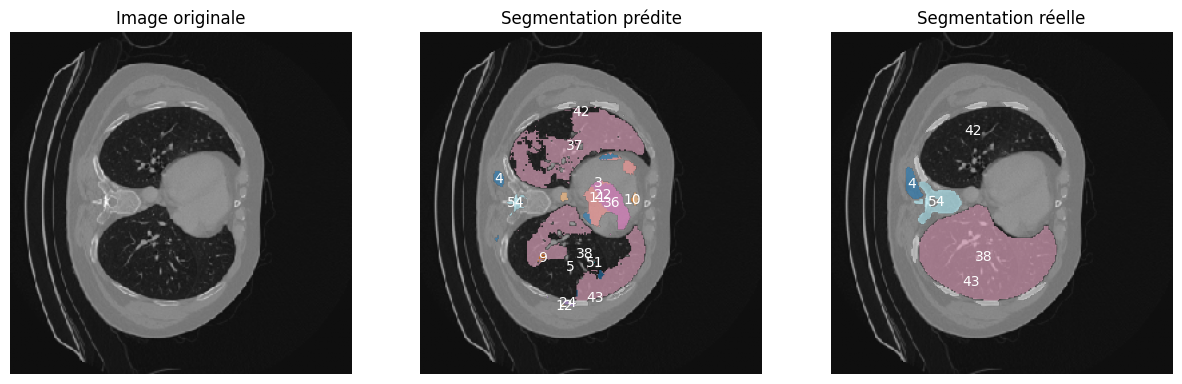

In [ ]:
# Fonction pour afficher une image, sa prédiction et son label réel
def plot_slice_seg(image, pred, label, idx=0):
    """
    Affiche une image en niveaux de gris avec la segmentation prédite et la segmentation réelle.

    image : image originale (3D ou 2D)
    pred  : prédiction du modèle (2D, classes)
    label : ground truth (2D, classes)
    idx   : index de l'exemple à afficher
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Affichage de l'image originale
    axes[0].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[0].set_title("Image originale")

    # Affichage de la prédiction
    pred_masked = np.ma.masked_where(pred[idx % pred.shape[0]] == 0, pred[idx % pred.shape[0]])  # Masquer le fond (classe 0) # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[1].imshow(pred_masked, cmap="tab20", alpha=0.6)
    axes[1].set_title("Segmentation prédite")

    # Affichage du label réel
    label_masked = np.ma.masked_where(label[idx % label.shape[0]] == 0, label[idx % label.shape[0]]) # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(image[idx % image.shape[0]].squeeze(), cmap="gray") # Use modulo operator to ensure idx is within bounds
    axes[2].imshow(label_masked, cmap="tab20", alpha=0.6)
    axes[2].set_title("Segmentation réelle")

    # Ajout des numéros de classe
    for i in range(1, NUM_CLASSES + 1): # On ignore le fond (classe 0)
        # Trouver les coordonnées des pixels appartenant à la classe i
        pred_coords = np.argwhere(pred[idx % pred.shape[0]] == i)
        label_coords = np.argwhere(label[idx % label.shape[0]] == i)

        # Afficher le numéro de classe au centre de la zone (approximativement)
        if len(pred_coords) > 0:
            center_pred = pred_coords.mean(axis=0).astype(int)
            axes[1].text(center_pred[1], center_pred[0], str(i), color='white', ha='center', va='center')
        if len(label_coords) > 0:
            center_label = label_coords.mean(axis=0).astype(int)
            axes[2].text(center_label[1], center_label[0], str(i), color='white', ha='center', va='center')


    for ax in axes:
        ax.axis("off")

    plt.show()

# Sélectionner un index aléatoire pour visualiser un exemple de validation
idx = np.random.randint(len(val_dataset)-1)  # Si val_dataset est ta liste d'images de validation

# Get a batch of images, labels, and features from the validation loader at the random index
image, label, feature = val_dataset[idx]
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
feature = feature.unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    output = model_fine_tuning(image, feature)  # Get the model's prediction
    pred = torch.argmax(output, dim=1).cpu().numpy()  # Get the predicted class labels

plot_slice_seg(
    image.cpu().numpy(),  # Images d'entrée (tensor → NumPy)
    pred,  # Prédictions (déjà en NumPy)
    label.unsqueeze(0).numpy(),  # Labels réels (déjà en NumPy) # Add batch dimension
    idx  # Index to use for plotting (always 0 since we're using a single image)
)